In [2]:
!pip install mmcv

     |████████████████████████████████| 295 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 185 kB 4.7 MB/s eta 0:00:01
  Created wheel for mmcv: filename=mmcv-1.3.4-py2.py3-none-any.whl size=426558 sha256=c96787b9978ae716909746cefd1b6be05d9270d324675591fd02cbbad81166df
  Stored in directory: /root/.cache/pip/wheels/7c/32/6c/e54dfd9b53986cefcbcafe9030f0424c0fd368621b873c4d55
Successfully built mmcv


In [3]:
from distutils.dir_util import copy_tree

# copy subdirectory example
fromDirectory = '../input/trimmed-ucf-part-1'
toDirectory = './merged_data'

copy_tree(fromDirectory, toDirectory)

['./merged_data/Robbery117_x264_incident_0.mp4',
 './merged_data/Arrest008_x264_incident_0.mp4',
 './merged_data/Arrest035_x264_incident_1.mp4',
 './merged_data/Explosion009_x264_incident_0.mp4',
 './merged_data/Burglary040_x264_incident_2.mp4',
 './merged_data/Fighting007_x264_incident_1.mp4',
 './merged_data/Abuse017_x264_incident_3.mp4',
 './merged_data/RoadAccidents013_x264_incident_0.mp4',
 './merged_data/RoadAccidents109_x264_incident_0.mp4',
 './merged_data/Fighting043_x264_incident_0.mp4',
 './merged_data/RoadAccidents036_x264_incident_0.mp4',
 './merged_data/Fighting043_x264_incident_1.mp4',
 './merged_data/Fighting046_x264_incident_0.mp4',
 './merged_data/Abuse050_x264_incident_7.mp4',
 './merged_data/Robbery136_x264_incident_0.mp4',
 './merged_data/Abuse014_x264_incident_0.mp4',
 './merged_data/Assault049_x264_incident_1.mp4',
 './merged_data/RoadAccidents028_x264_incident_0.mp4',
 './merged_data/Assault016_x264_incident_0.mp4',
 './merged_data/Arson015_x264_incident_0.mp4',

In [4]:
# copy subdirectory example
fromDirectory = '../input/trimmed-ucf-part-2'
toDirectory = './merged_data'

copy_tree(fromDirectory, toDirectory)

['./merged_data/Vandalism029_x264_incident_0.mp4',
 './merged_data/Vandalism046_x264_incident_0.mp4',
 './merged_data/Shoplifting009_x264_incident_1.mp4',
 './merged_data/Shooting017_x264_incident_0.mp4',
 './merged_data/Normal_Videos_781_x264.mp4',
 './merged_data/Stealing032_x264_incident_0.mp4',
 './merged_data/Stealing075_x264_incident_0.mp4',
 './merged_data/Shoplifting040_x264_incident_0.mp4',
 './merged_data/Normal_Videos_696_x264.mp4',
 './merged_data/Vandalism008_x264_incident_0.mp4',
 './merged_data/Stealing105_x264_incident_0.mp4',
 './merged_data/Shoplifting003_x264_incident_2.mp4',
 './merged_data/Shoplifting041_x264_incident_2.mp4',
 './merged_data/Stealing072_x264_incident_0.mp4',
 './merged_data/Vandalism013_x264_incident_0.mp4',
 './merged_data/Stealing063_x264_incident_0.mp4',
 './merged_data/Shoplifting030_x264_incident_0.mp4',
 './merged_data/Shooting052_x264_incident_0.mp4',
 './merged_data/Shooting027_x264_incident_0.mp4',
 './merged_data/Shooting054_x264_incident

In [5]:
!nvidia-smi

Sat May 22 10:01:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
from __future__ import division

import argparse, time, logging, os, sys, math

import numpy as np
import mxnet as mx
import gluoncv as gcv
from mxnet import gluon, nd, init, context
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.data.transforms import video
from gluoncv.data import VideoClsCustom
from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, LRSequential, LRScheduler, split_and_load, TrainingHistory

In [7]:
num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]
transform_train = video.VideoGroupTrainTransform(size=(224, 224), scale_ratios=[1.0, 0.8], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
per_device_batch_size = 15
num_workers = 0
batch_size = per_device_batch_size * num_gpus

train_dataset = VideoClsCustom(root=os.path.expanduser('./merged_data'),
                               setting=os.path.expanduser('../input/trimmed-ucf-annotations/gluon_annotations_with_normal.txt'),
                               train=True,
                               new_length=32,
                               video_loader=True,
#                                slowfast=True,
#                                slow_temporal_stride=16,
#                                fast_temporal_stride=2,
                               transform=transform_train)
print('Load %d training samples.' % len(train_dataset))
train_data = gluon.data.DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)

Load 1252 training samples.


In [8]:
# net = get_model(name='slowfast_4x16_resnet50_custom',pretrained=False, pretrained_base=True, nclass=14)
net = get_model(name='i3d_resnet50_v1_custom',pretrained=False, pretrained_base=True, nclass=14)
net.collect_params().reset_ctx(ctx)
print(net)

100%|██████████| 55344/55344 [00:03<00:00, 16789.20KB/s]


conv0_weight is done with shape:  (64, 3, 5, 7, 7)
batchnorm0_gamma is done with shape:  (64,)
batchnorm0_beta is done with shape:  (64,)
batchnorm0_running_mean is done with shape:  (64,)
batchnorm0_running_var is done with shape:  (64,)
layer1_0_conv0_weight is done with shape:  (64, 64, 3, 1, 1)
layer1_0_batchnorm0_gamma is done with shape:  (64,)
layer1_0_batchnorm0_beta is done with shape:  (64,)
layer1_0_batchnorm0_running_mean is done with shape:  (64,)
layer1_0_batchnorm0_running_var is done with shape:  (64,)
layer1_0_conv1_weight is done with shape:  (64, 64, 1, 3, 3)
layer1_0_batchnorm1_gamma is done with shape:  (64,)
layer1_0_batchnorm1_beta is done with shape:  (64,)
layer1_0_batchnorm1_running_mean is done with shape:  (64,)
layer1_0_batchnorm1_running_var is done with shape:  (64,)
layer1_0_conv2_weight is done with shape:  (256, 64, 1, 1, 1)
layer1_0_batchnorm2_gamma is done with shape:  (256,)
layer1_0_batchnorm2_beta is done with shape:  (256,)
layer1_0_batchnorm2_ru

100%|██████████| 208483/208483 [00:10<00:00, 20302.15KB/s]


I3D_ResNetV1(
  (first_stage): HybridSequential(
    (0): Conv3D(3 -> 64, kernel_size=(5, 7, 7), stride=(2, 2, 2), padding=(2, 3, 3), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
    (2): Activation(relu)
    (3): MaxPool3D(size=(1, 3, 3), stride=(2, 2, 2), padding=(0, 1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCDHW)
  )
  (pool2): MaxPool3D(size=(2, 1, 1), stride=(2, 1, 1), padding=(0, 0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCDHW)
  (res_layers): HybridSequential(
    (0): HybridSequential(
      (0): Bottleneck(
        (bottleneck): HybridSequential(
          (0): Conv3D(64 -> 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
          (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
          (2): Activation(relu)
          (3): Conv3D(64 -> 64, kernel_size=(1, 3, 3), stride=(1

In [9]:
# Learning rate decay factor
lr_decay = 0.1
# Epochs where learning rate decays
lr_decay_epoch = [40, 80, 100]

# Stochastic gradient descent
optimizer = 'adam'
# Set parameters
optimizer_params = {'learning_rate': 0.0005}

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()
train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-acc'])

[Epoch 0] train=0.179712 loss=2.485923 time: 335.670999
[Epoch 1] train=0.258786 loss=2.333906 time: 287.636511
[Epoch 2] train=0.276358 loss=2.253768 time: 287.741205
[Epoch 3] train=0.285144 loss=2.183461 time: 287.328809
[Epoch 4] train=0.333067 loss=2.100115 time: 287.759283
[Epoch 5] train=0.323482 loss=2.063653 time: 286.463169
[Epoch 6] train=0.363419 loss=1.990466 time: 287.240812
[Epoch 7] train=0.357029 loss=1.989366 time: 286.128913
[Epoch 8] train=0.352236 loss=1.962215 time: 286.842791
[Epoch 9] train=0.410543 loss=1.863968 time: 286.273117
[Epoch 10] train=0.382588 loss=1.859093 time: 285.792481
[Epoch 11] train=0.416134 loss=1.827544 time: 284.116638
[Epoch 12] train=0.436102 loss=1.765236 time: 285.566777
[Epoch 13] train=0.437700 loss=1.744768 time: 284.812218
[Epoch 14] train=0.464856 loss=1.664061 time: 284.961241
[Epoch 15] train=0.448083 loss=1.671814 time: 283.320807
[Epoch 16] train=0.485623 loss=1.644305 time: 284.481158
[Epoch 17] train=0.496006 loss=1.601336 t

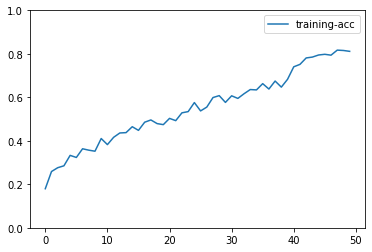

In [10]:
epochs = 50
lr_decay_count = 0

for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        lr_decay_count += 1

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = []
            for _, X in enumerate(data):
                X = X.reshape((-1,) + X.shape[2:])
                pred = net(X)
                output.append(pred)
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.mean().asscalar() for l in loss])
        train_metric.update(label, output)

        if i == 100:
            break

    name, acc = train_metric.get()

    # Update history and print metrics
    train_history.update([acc])
    print('[Epoch %d] train=%f loss=%f time: %f' %
        (epoch, acc, train_loss / (i+1), time.time()-tic))

# We can plot the metric scores with:
train_history.plot()

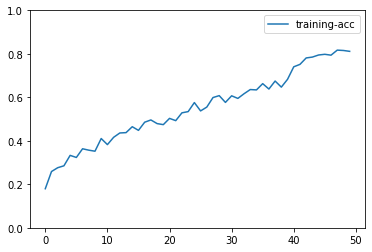

In [11]:
train_history.plot()

In [12]:
val_dataset = VideoClsCustom(root=os.path.expanduser('../input/trimmed-ucf-test'),
                               setting=os.path.expanduser('../input/trimmed-ucf-test-annotations/gluon_annotations.txt'),
                               train=False,
                               new_length=32,
                               video_loader=True,
#                                slowfast=True,
#                                slow_temporal_stride=16,
#                                fast_temporal_stride=2,
                               transform=transform_train)
print('Load %d training samples.' % len(val_dataset))
val_data = gluon.data.DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=False, num_workers=num_workers)

Load 156 training samples.


In [13]:
# Use Accuracy as the evaluation metric.
metric = mx.metric.Accuracy()

# Loop through each batch of training data
for i, batch in enumerate(val_data):
    # Extract data and label
    data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
    label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

    output = []
    for _, X in enumerate(data):
        X = X.reshape((-1,) + X.shape[2:])
        pred = net(X)
        output.append(pred)
    # Updates internal evaluation
    metric.update(label, output)
        
print('validation acc: %s=%f'%metric.get())

validation acc: accuracy=0.901757


In [1]:
file_name = "ucf_crime_i3d_resnet50.params"
net.save_parameters(file_name)

NameError: name 'net' is not defined